# Third Model: Decision Tree Classifier with Reduced Features and Categories

The goal of this model is to make a better Decision Tree that can more accurately predict the minority class correctly. Our biggest obstacle was high dimensionality. It was distracting both of our models from focusing on what was important. This time we will tell it what is important.

### Methods:

Feature Selection: I will use domain knowledge select the most important features. The feature importance method was not helpful as all the feature scores were very close to zero.

Category Reduction: I will group together similar categories to reduce dimensionality.



In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [139]:
#Load in the dataset
diabetes_df = pd.read_csv('cleaned_diabetes_data.csv', index_col=0)

In [140]:
diabetes_df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

## Feature Engineering

Adjusting data types of categorical variables

In [141]:
diabetes_df['admission_type_id'] = diabetes_df['admission_type_id'].astype('object')
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].astype('object')
diabetes_df['discharge_disposition_id'] = diabetes_df['discharge_disposition_id'].astype('object')

In [142]:
diabetes_df[['time_in_hospital','num_lab_procedures',
       'num_procedures', 'num_medications','number_diagnoses']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
time_in_hospital,1.000000,0.332180,0.188305,0.467897,0.233850
num_lab_procedures,0.332180,1.000000,0.043781,0.258975,0.153981
num_procedures,0.188305,0.043781,1.000000,0.400873,0.086476
num_medications,0.467897,0.258975,0.400873,1.000000,0.259283
number_diagnoses,0.233850,0.153981,0.086476,0.259283,1.000000


### Creating the A1Cmeasurement column: 

Exploring the effect of whether not A1C is measured has some impact on the target variable

In [143]:
diabetes_df['A1Cresult'].value_counts()

A1Cresult
Missing    57128
>8          6239
Norm        3741
>7          2865
Name: count, dtype: int64

In [144]:
temp_table = diabetes_df['A1Cresult'].replace(to_replace=['>8','>7','Norm'], value='Yes')

In [145]:
temp_table

0         Missing
1         Missing
2         Missing
3         Missing
4         Missing
           ...   
101754        Yes
101755        Yes
101756    Missing
101758    Missing
101765    Missing
Name: A1Cresult, Length: 69973, dtype: object

In [146]:
A1Cmeasurement = temp_table.replace(to_replace='Missing', value='No')


In [147]:
A1Cmeasurement = A1Cmeasurement.rename('A1Cmeasurement')

In [148]:
A1Cmeasurement

0          No
1          No
2          No
3          No
4          No
         ... 
101754    Yes
101755    Yes
101756     No
101758     No
101765     No
Name: A1Cmeasurement, Length: 69973, dtype: object

In [149]:
diabetes_df = diabetes_df.join(A1Cmeasurement, how='left')

In [150]:
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cmeasurement
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,Otherwise,No
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,No,Yes,Otherwise,No
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,Steady,No,No,No,No,No,Ch,Yes,Otherwise,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,Steady,No,No,No,No,No,Ch,Yes,Otherwise,Yes
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,Yes
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,Steady,No,No,No,No,No,No,Yes,Otherwise,No
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No


In [151]:
diabetes_df['max_glu_serum'].value_counts()

max_glu_serum
Missing    66625
Norm        1700
>200         936
>300         712
Name: count, dtype: int64

In [152]:
temp_table_2 = diabetes_df['max_glu_serum'].replace(to_replace=['>200','>300','Norm'], value='Yes')

In [153]:
Glucose_Measured = temp_table_2.replace(to_replace='Missing', value='No')

In [154]:
Glucose_Measured = Glucose_Measured.rename('Glucose_Measured')

In [155]:
diabetes_df = diabetes_df.join(Glucose_Measured, how='left')
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cmeasurement,Glucose_Measured
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,Otherwise,No,No
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,Yes,Otherwise,No,No
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,No,No,No,No,No,Ch,Yes,Otherwise,Yes,No
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,No,No,No,No,No,Ch,Yes,Otherwise,Yes,No
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,No,No,No,No,No,No,Yes,Otherwise,No,No
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No


In [156]:
diabetes_df.isna().value_counts()

race   gender  age    admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital  payer_code  medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  rosiglitazone  acarbose  miglitol  troglitazone  tolazamide  examide  citoglipton  insulin  glyburide-metformin  glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed  readmitted  A1Cmeasurement  Glucose_Measured
False  False   False  False              False                     False                False             False       False              False               False           False            False              False             False             False   False   False   False        

So we created 2 new columns to signify whether or not glucose and Hemoglobin A1C were measured during the patient's visit. If these are statistically significant variables, we will be able to use them as predictors for our model

In [157]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['A1Cmeasurement'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(6.355505830669563,
 0.011701757602602935,
 1,
 array([[ 5124.72605148, 52003.27394852],
        [ 1152.27394852, 11692.72605148]]))

The p-value of is .01, which is less than alpha .05. We can reject the null and say that this is in fact a statistically significant variable for our target.

In [158]:
contingency_table

readmitted,<30,Otherwise
A1Cmeasurement,,
No,5199,51929
Yes,1078,11767


In [159]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['A1Cresult'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(7.260008315545734,
 0.06405633904985746,
 3,
 array([[  257.00777443,  2607.99222557],
        [  559.67591785,  5679.32408215],
        [ 5124.72605148, 52003.27394852],
        [  335.59025624,  3405.40974376]]))

The actual A1C result is not statistically significant here so we won't include this in our reduced dataframe.

In [160]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['age'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(188.13382228360737,
 1.0114177173089188e-35,
 9,
 array([[1.37250225e+01, 1.39274977e+02],
        [4.79030197e+01, 4.86096980e+02],
        [1.00560459e+02, 1.02043954e+03],
        [2.41488631e+02, 2.45051137e+03],
        [6.12512769e+02, 6.21548723e+03],
        [1.10777976e+03, 1.12412202e+04],
        [1.40694937e+03, 1.42770506e+04],
        [1.59228202e+03, 1.61577180e+04],
        [9.95916339e+02, 1.01060837e+04],
        [1.57882612e+02, 1.60211739e+03]]))

Age is statistically signficant.

In [161]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['gender'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(0.6113260258097654,
 0.7366348140607145,
 2,
 array([[3.33966577e+03, 3.38893342e+04],
        [2.93706511e+03, 2.98039349e+04],
        [2.69118088e-01, 2.73088191e+00]]))

Gender is not statistically significant

In [162]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['race'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(18.210752754882044,
 0.002693546379127181,
 5,
 array([[1.13253862e+03, 1.14924614e+04],
        [4.37765424e+01, 4.44223458e+02],
        [4.69090769e+03, 4.76010923e+04],
        [1.34559044e+02, 1.36544096e+03],
        [1.03161934e+02, 1.04683807e+03],
        [1.72056165e+02, 1.74594384e+03]]))

Race is statistically significant

In [163]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['admission_type_id'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(18.872430526679967,
 0.008596497460928193,
 7,
 array([[3.18151404e+03, 3.22844860e+04],
        [1.14841659e+03, 1.16535834e+04],
        [1.23659762e+03, 1.25484024e+04],
        [8.07354265e-01, 8.19264573e+00],
        [2.76832807e+02, 2.80916719e+03],
        [4.05112429e+02, 4.11088757e+03],
        [1.61470853e+00, 1.63852915e+01],
        [2.61044546e+01, 2.64895545e+02]]))

Admission type is statistically significant

In [164]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['payer_code'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(133.09886182224145,
 4.735512091613653e-20,
 17,
 array([[3.04731382e+02, 3.09226862e+03],
        [1.01367813e+01, 1.02863219e+02],
        [1.16169308e+02, 1.17883069e+03],
        [1.73939991e+02, 1.76506001e+03],
        [3.33706430e+01, 3.38629357e+02],
        [8.97060295e-02, 9.10293971e-01],
        [3.57388821e+02, 3.62661118e+03],
        [1.77456467e+03, 1.80074353e+04],
        [1.94213554e+02, 1.97078645e+03],
        [2.87059294e+00, 2.91294071e+01],
        [5.80398011e+01, 5.88960199e+02],
        [5.56177383e+00, 5.64382262e+01],
        [4.09956555e+01, 4.16004345e+02],
        [3.31912309e+00, 3.36808769e+01],
        [2.96299015e+02, 3.00670098e+03],
        [1.66404685e+02, 1.68859532e+03],
        [2.72840889e+03, 2.76865911e+04],
        [1.04956054e+01, 1.06504395e+02]]))

Payer code is statistically significant

In [165]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['time_in_hospital'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(274.18868404668183,
 5.92540801142587e-51,
 13,
 array([[  939.22212854,  9530.77787146],
        [ 1092.44002687, 11085.55997313],
        [ 1120.15918997, 11366.84081003],
        [  845.29991568,  8577.70008432],
        [  600.76127935,  6096.23872065],
        [  453.01544882,  4596.98455118],
        [  350.03292699,  3551.96707301],
        [  255.03424178,  2587.96575822],
        [  171.42822231,  1739.57177769],
        [  135.09728038,  1370.90271962],
        [  106.57076301,  1081.42923699],
        [   82.08101696,   832.91898304],
        [   68.26628843,   692.73371157],
        [   57.59127092,   584.40872908]]))

Time in hospital is statistically significant

In [166]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_lab_procedures'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(227.33783363021905,
 2.190847541795524e-09,
 115,
 array([[2.02197390e+02, 2.05180261e+03],
        [6.93427608e+01, 7.03657239e+02],
        [4.53912509e+01, 4.60608749e+02],
        [2.63735727e+01, 2.67626427e+02],
        [1.91073843e+01, 1.93892616e+02],
        [1.78514999e+01, 1.81148500e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.38618038e+01, 2.42138196e+02],
        [6.10898061e+01, 6.19910194e+02],
        [5.21192031e+01, 5.28880797e+02],
        [4.30588941e+01, 4.36941106e+02],
        [3.31015249e+01, 3.35898475e+02],
        [2.64632787e+01, 2.68536721e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.53868063e+01, 2.57613194e+02],
        [3.21147585e+01, 3.25885241e+02],
        [4.23412459e+01, 4.29658754e+02],
        [4.31486002e+01, 4.37851400e+02],
        [6.36912809e+01, 6.46308719e+02],
        [5.15809669e+01, 5.23419033e+02],
        [4.79030197e+01, 4.86096980e+02],
        [4.44941906e+01, 4.51505809e+02],
        [5.36442056e+01, 

Number of lab procedures is statistically significant

In [167]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['diag_1'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(1434.0837881144912,
 9.395940707022191e-54,
 694,
 array([[0.08970603, 0.91029397],
        [0.71764824, 7.28235176],
        [0.17941206, 1.82058794],
        ...,
        [0.08970603, 0.91029397],
        [0.08970603, 0.91029397],
        [0.71764824, 7.28235176]]))

Primary diagnosis is statistically significant

In [168]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_medications'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(240.31918893838173,
 1.8562809970227165e-19,
 74,
 array([[1.93765024e+01, 1.96623498e+02],
        [3.50750575e+01, 3.55924942e+02],
        [6.35118689e+01, 6.44488131e+02],
        [1.02803110e+02, 1.04319689e+03],
        [1.42901705e+02, 1.45009830e+03],
        [1.87665014e+02, 1.90433499e+03],
        [2.38528332e+02, 2.42047167e+03],
        [2.89122533e+02, 2.93387747e+03],
        [3.24107884e+02, 3.28889212e+03],
        [3.45727038e+02, 3.50827296e+03],
        [3.60349120e+02, 3.65665088e+03],
        [3.80532977e+02, 3.86146702e+03],
        [3.82057980e+02, 3.87694202e+03],
        [3.44650565e+02, 3.49734943e+03],
        [3.49225573e+02, 3.54377443e+03],
        [3.26888771e+02, 3.31711123e+03],
        [2.92082832e+02, 2.96391717e+03],
        [2.63556315e+02, 2.67444369e+03],
        [2.32159204e+02, 2.35584080e+03],
        [2.11437111e+02, 2.14556289e+03],
        [1.83448830e+02, 1.86155117e+03],
        [1.63803210e+02, 1.66219679e+03],
        [1.40210524e+02, 

Number of medications is statistically significant

In [169]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['max_glu_serum'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(6.9942155454614605,
 0.07208237144251027,
 3,
 array([[   83.96484358,   852.03515642],
        [   63.87069298,   648.12930702],
        [ 5976.66421334, 60648.33578666],
        [  152.5002501 ,  1547.4997499 ]]))

The glucose result is not statistically significant

In [170]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['Glucose_Measured'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 



(5.892279472467756,
 0.015207403378144534,
 1,
 array([[ 5976.66421334, 60648.33578666],
        [  300.33578666,  3047.66421334]]))

Glucose measured is statistically significant!

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values


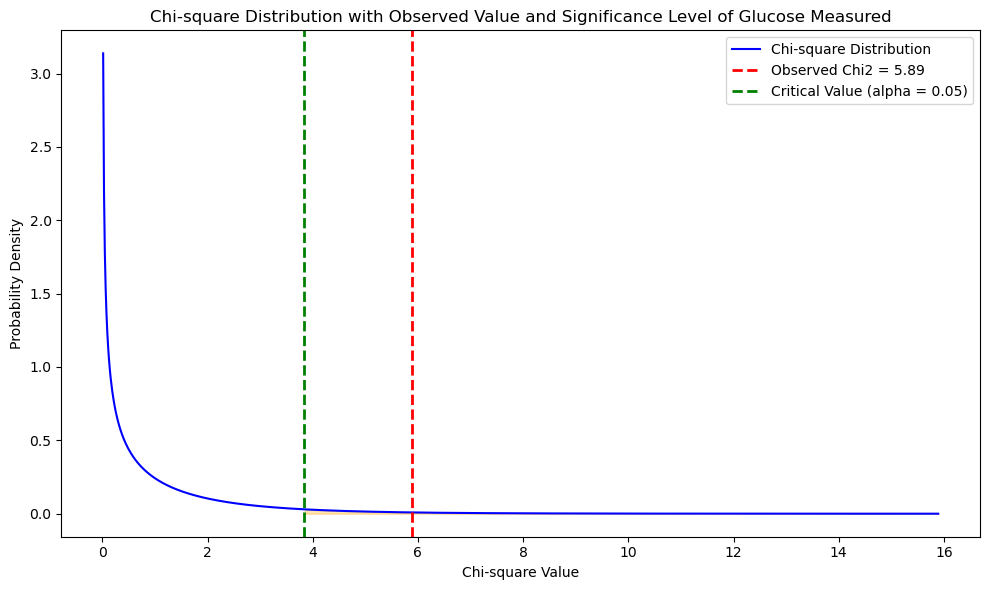

In [171]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2

# Generate the contingency table
contingency_table = pd.crosstab(diabetes_df['Glucose_Measured'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2_stat, p, dof, expected = chi2_contingency(contingency_table)

# Define the critical chi-square value for alpha = 0.05
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, dof)

# Generate values for the chi-square distribution curve
x_values = np.linspace(0, chi2_stat + 10, 1000)
y_values = chi2.pdf(x_values, dof)

# Plot the chi-square distribution curve
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label="Chi-square Distribution", color="blue")

# Add a vertical line for the observed chi-square value
plt.axvline(chi2_stat, color="red", linestyle="--", linewidth=2, label=f"Observed Chi2 = {chi2_stat:.2f}")

# Add a vertical line for the critical value at alpha = 0.05
plt.axvline(critical_value, color="green", linestyle="--", linewidth=2, label=f"Critical Value (alpha = {alpha})")

# Fill the rejection region
plt.fill_between(x_values, 0, y_values, where=(x_values >= critical_value), color='orange', alpha=0.3)

# Display p-value, chi-square, and significance level
plt.text(chi2_stat + 1, max(y_values) * 0.6, f"p-value: {p:.4f}", color='red', ha='center')
plt.text(critical_value + 1, max(y_values) * 0.7, f"alpha = {alpha}", color='green', ha='center')
plt.xlabel("Chi-square Value")
plt.ylabel("Probability Density")
plt.title("Chi-square Distribution with Observed Value and Significance Level of Glucose Measured")
plt.legend()

plt.tight_layout()
plt.savefig('Glucose_Measured_Significance')


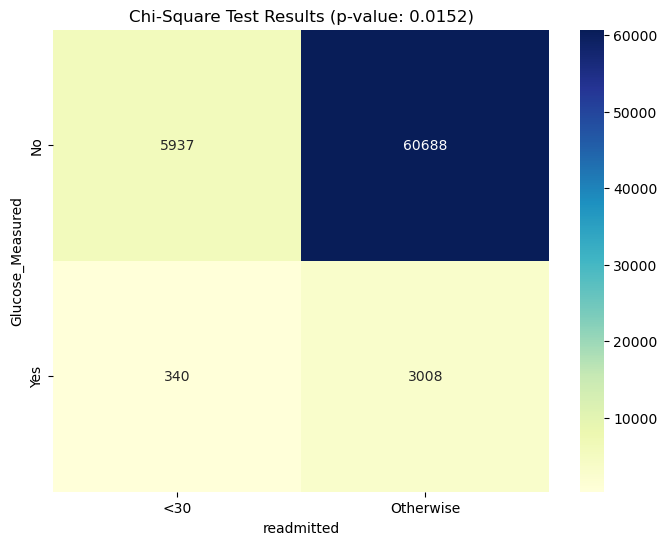

In [172]:
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Chi-Square Test Results (p-value: {p:.4f})")
plt.savefig('Glucose_Measured_Contingency.png')


In [173]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_lab_procedures'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(227.33783363021905,
 2.190847541795524e-09,
 115,
 array([[2.02197390e+02, 2.05180261e+03],
        [6.93427608e+01, 7.03657239e+02],
        [4.53912509e+01, 4.60608749e+02],
        [2.63735727e+01, 2.67626427e+02],
        [1.91073843e+01, 1.93892616e+02],
        [1.78514999e+01, 1.81148500e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.38618038e+01, 2.42138196e+02],
        [6.10898061e+01, 6.19910194e+02],
        [5.21192031e+01, 5.28880797e+02],
        [4.30588941e+01, 4.36941106e+02],
        [3.31015249e+01, 3.35898475e+02],
        [2.64632787e+01, 2.68536721e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.53868063e+01, 2.57613194e+02],
        [3.21147585e+01, 3.25885241e+02],
        [4.23412459e+01, 4.29658754e+02],
        [4.31486002e+01, 4.37851400e+02],
        [6.36912809e+01, 6.46308719e+02],
        [5.15809669e+01, 5.23419033e+02],
        [4.79030197e+01, 4.86096980e+02],
        [4.44941906e+01, 4.51505809e+02],
        [5.36442056e+01, 

Number of Lab procedures is statistically significant

In [174]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['insulin'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(50.626250842006954,
 5.87644764524392e-11,
 3,
 array([[  656.73784174,  6664.26215826],
        [ 3073.14915753, 31184.85084247],
        [ 1939.17523902, 19677.82476098],
        [  607.93776171,  6169.06223829]]))

Insulin measurement is also statistically significant

In [175]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['change'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(14.983439258895487,
 0.00010845884202377609,
 1,
 array([[ 2824.93257399, 28666.06742601],
        [ 3452.06742601, 35029.93257399]]))

Change in medication is statistically significant

In [176]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['diabetesMed'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(54.05200384318759,
 1.9525288585115278e-13,
 1,
 array([[ 1496.29657153, 15183.70342847],
        [ 4780.70342847, 48512.29657153]]))

Prescribed diabetes medication is also statisically significant

## Feature Selection

Based on domain knowledge and statistical significance of variables


In [177]:
reduced_df = diabetes_df[['race', 'age', 'payer_code',
                                           'admission_type_id','time_in_hospital',
                                           'num_lab_procedures','diag_1', 'num_medications',
                                           'Glucose_Measured', 'A1Cmeasurement',
                                           'insulin','change', 'readmitted']]
reduced_df


,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,readmitted
0,Caucasian,[0-10),Unknown,6,1,41,250.83,1,No,No,No,No,Otherwise
1,Caucasian,[10-20),Unknown,1,3,59,276,18,No,No,Up,Ch,Otherwise
2,AfricanAmerican,[20-30),Unknown,1,2,11,648,13,No,No,No,No,Otherwise
3,Caucasian,[30-40),Unknown,1,2,44,8,16,No,No,Up,Ch,Otherwise
4,Caucasian,[40-50),Unknown,1,1,51,197,8,No,No,Steady,Ch,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,[70-80),Unknown,1,9,50,574,33,No,Yes,Steady,Ch,Otherwise
101755,Other,[40-50),MD,1,14,73,592,26,No,Yes,Up,Ch,Otherwise
101756,Other,[60-70),MD,1,2,46,996,17,No,No,Steady,No,Otherwise
101758,Caucasian,[80-90),MC,1,5,76,292,22,No,No,Up,Ch,Otherwise


## Reducing Categories/Cardinality

Grouping together similar categories to reduce dimensionality

There's very few values for for Hispanic and Asian patients so we will group them together with other.

In [178]:
reduced_df['race'].value_counts()
# Group together Unknown, Hispanic, Other, and Asian into one category called 'Other'
reduced_df['race'] = reduced_df['race'].replace(['Unknown', 'Hispanic', 'Other', 'Asian'], 'Other')

# Display the updated race distribution
reduced_df['race'].value_counts()

#Fix the data type
reduced_df['race'] = reduced_df['race'].astype('object')

reduced_df['race']



/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/1106187330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['race'] = reduced_df['race'].replace(['Unknown', 'Hispanic', 'Other', 'Asian'], 'Other')
/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/1106187330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['race'] = reduced_df['race'].astype('object')


0               Caucasian
1               Caucasian
2         AfricanAmerican
3               Caucasian
4               Caucasian
               ...       
101754          Caucasian
101755              Other
101756              Other
101758          Caucasian
101765          Caucasian
Name: race, Length: 69973, dtype: object

The special characters may be a source noise that distracts the model so we will transform them inot numerical representations.

In [179]:
#Convert age to numeric representations
def age_to_numeric(age_range):
    if age_range == '[0-10)':
        return 5
    elif age_range == '[10-20)':
        return 15
    elif age_range == '[20-30)':
        return 25
    elif age_range == '[30-40)':
        return 35
    elif age_range == '[40-50)':
        return 45
    elif age_range == '[50-60)':
        return 55
    elif age_range == '[60-70)':
        return 65
    elif age_range == '[70-80)':
        return 75
    elif age_range == '[80-90)':
        return 85
    elif age_range == '[90-100)':
        return 95
    else:
        return None

reduced_df['age'] = reduced_df['age'].apply(age_to_numeric)


/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/2972771319.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['age'] = reduced_df['age'].apply(age_to_numeric)


In [180]:
reduced_df['age'].value_counts()

age
75    17750
65    15684
55    12349
85    11102
45     6828
35     2692
95     1760
25     1121
15      534
5       153
Name: count, dtype: int64

Grouping Admission Type Categories

In [181]:
reduced_df['admission_type_id'].value_counts()

admission_type_id
1    35466
3    13785
2    12802
6     4516
5     3086
8      291
7       18
4        9
Name: count, dtype: int64

Admission Type mapping:
1,Emergency
2,Urgent
3,Elective
4,Newborn
5,Not Available
6,NULL
7,Trauma Center
8,Not Mapped

We'll group together Emergency and Urgent and group together Not Available, Null, and Not Mapped to reduce cardinality.

The new categories;
1. Emergency/Urgent
2. Elective
3. Newborn
4. Not Available, Null, Not Mapped
5. Trauma Center

In [182]:
#Group together similar admission types to reduce dimensionality
reduced_df['admission_type_id'] = reduced_df['admission_type_id'].replace({
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 4,
    8: 4,
    7: 5
})

# Verify the changes
print(reduced_df['admission_type_id'].value_counts().sort_index())



/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/1521505962.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reduced_df['admission_type_id'] = reduced_df['admission_type_id'].replace({


admission_type_id
1    48268
2    13785
3        9
4     7893
5       18
Name: count, dtype: int64


/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/1521505962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['admission_type_id'] = reduced_df['admission_type_id'].replace({


Starting with 695 unique values for diagnosis 1

In [183]:
diabetes_df['diag_1'].value_counts()

diag_1
414    5209
428    3876
786    3040
410    2774
486    2362
       ... 
671       1
148       1
826       1
870       1
V51       1
Name: count, Length: 695, dtype: int64

Grouping together diagnosis categories:

In [184]:
def categorize_diagnosis(code):
    code = str(code).strip()
    if code.startswith('250'):
        return 'Diabetes'
    elif 'V' in code or 'E' in code:
        return 'Other'
    elif code.isdigit():
        code_int = int(code)
        if 390 <= code_int <= 459 or code == '785':
            return 'Circulatory System'
        elif 460 <= code_int <= 519 or code == '786':
            return 'Respiratory System'
        elif 520 <= code_int <= 579 or code == '787':
            return 'Digestive System'
        elif 800 <= code_int <= 999:
            return 'Injury'
        elif 710 <= code_int <= 739:
            return 'Musculoskeletal System'
        elif 580 <= code_int <= 629 or code == '788':
            return 'Genitourinary System'
        elif 140 <= code_int <= 239:
            return 'Neoplasms'
        elif code in ['780', '781', '784'] or 790 <= code_int <= 799 or \
             (240 <= code_int <= 279 and code != '250') or \
             680 <= code_int <= 709 or code == '782' or \
             1 <= code_int <= 139 or 290 <= code_int <= 319 or \
             280 <= code_int <= 289 or 320 <= code_int <= 359 or \
             630 <= code_int <= 679 or 360 <= code_int <= 389 or \
             540 <= code_int <= 759:
            return 'Other'
    return 'Other'

# Ensure diag_1 is string type before applying the function
reduced_df['diag_1'] = reduced_df['diag_1'].astype(str)
reduced_df['diag_1'] = reduced_df['diag_1'].apply(categorize_diagnosis)
reduced_df['diag_1'].value_counts()

/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/3106606842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['diag_1'] = reduced_df['diag_1'].astype(str)
/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/3106606842.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['diag_1'] = reduced_df['diag_1'].apply(categorize_diagnosis)


diag_1
Circulatory System        21384
Other                     12132
Respiratory System         9486
Digestive System           6487
Diabetes                   5748
Injury                     4694
Musculoskeletal System     4064
Genitourinary System       3440
Neoplasms                  2538
Name: count, dtype: int64

In [185]:
reduced_df['diag_1']=reduced_df['diag_1'].astype('object')


/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/199267361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['diag_1']=reduced_df['diag_1'].astype('object')


In [186]:
reduced_df['diag_1']

0                     Diabetes
1                        Other
2                        Other
3                        Other
4                    Neoplasms
                  ...         
101754        Digestive System
101755    Genitourinary System
101756                  Injury
101758                   Other
101765        Digestive System
Name: diag_1, Length: 69973, dtype: object

There are 10 unique values for diagnosis 1 now.

In [187]:
reduced_df['diag_1'].value_counts()

diag_1
Circulatory System        21384
Other                     12132
Respiratory System         9486
Digestive System           6487
Diabetes                   5748
Injury                     4694
Musculoskeletal System     4064
Genitourinary System       3440
Neoplasms                  2538
Name: count, dtype: int64

In [188]:
reduced_df['admission_type_id']=reduced_df['admission_type_id'].astype('object')

/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/1711524336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['admission_type_id']=reduced_df['admission_type_id'].astype('object')


Checking for remaining outliers in numeric columns

Text(0.5, 1.0, 'Time in Hospital Distribution')

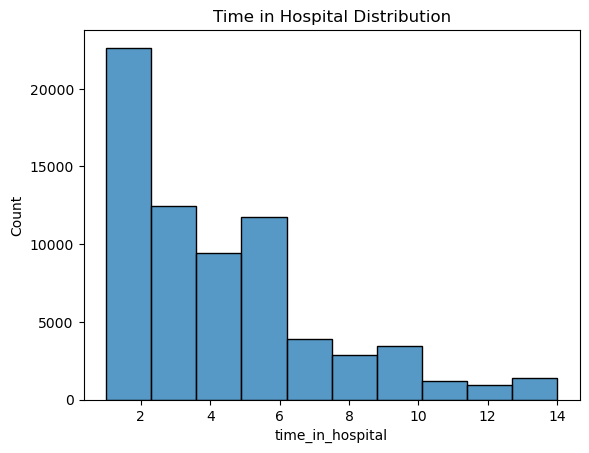

In [189]:
sns.histplot(data=reduced_df, x= 'time_in_hospital', bins=10)
plt.title('Time in Hospital Distribution')


Text(0.5, 1.0, 'Number of Medications Distribution')

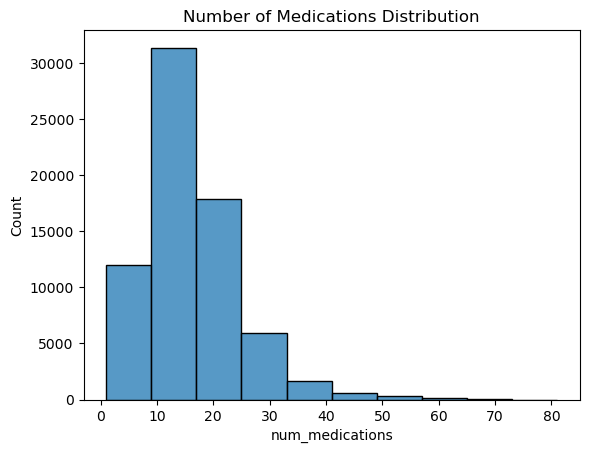

In [190]:
sns.histplot(data=reduced_df, x= 'num_medications', bins=10)
plt.title('Number of Medications Distribution')


Text(0.5, 1.0, 'Number of Medications Distribution')

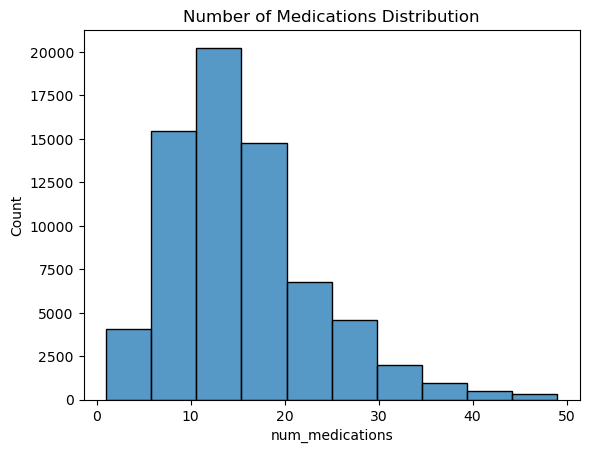

In [191]:
#Remove outliers in num_medications
reduced_df = reduced_df[reduced_df['num_medications'] < 50]

sns.histplot(data=reduced_df, x= 'num_medications', bins=10)
plt.title('Number of Medications Distribution')

Text(0.5, 1.0, 'Number of Lab Procedures Distribution')

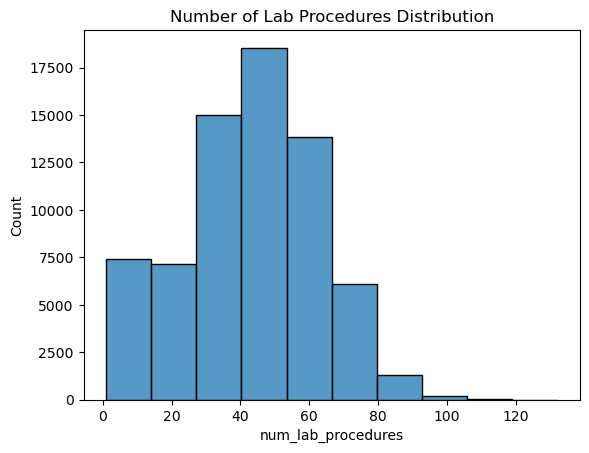

In [192]:
sns.histplot(data=reduced_df, x= 'num_lab_procedures', bins=10)
plt.title('Number of Lab Procedures Distribution')

Text(0.5, 1.0, 'Number of Lab Procedures Distribution')

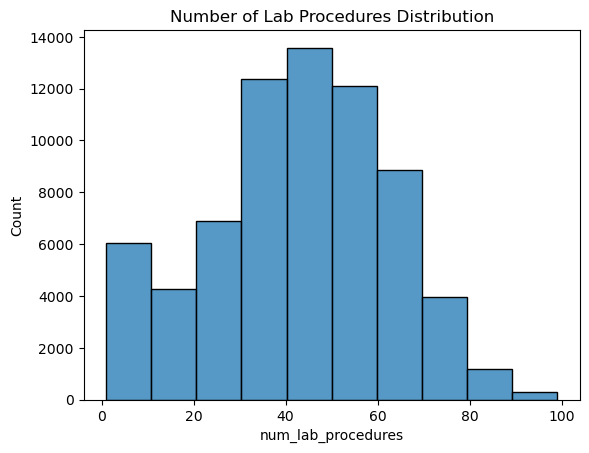

In [193]:
# Remove outliers in num_lab_procedures
reduced_df = reduced_df[reduced_df['num_lab_procedures'] < 100]

sns.histplot(data=reduced_df, x= 'num_lab_procedures', bins=10)
plt.title('Number of Lab Procedures Distribution')

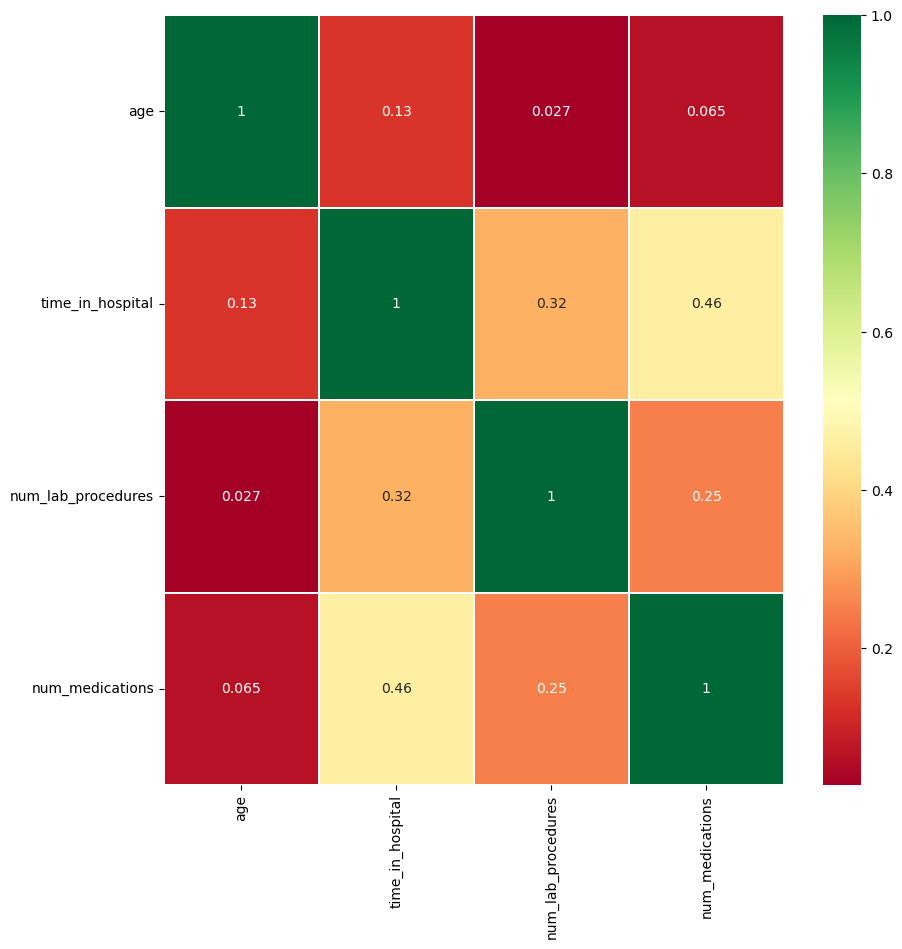

In [194]:

sns.heatmap(reduced_df.corr(numeric_only=True), annot=True, cmap='RdYlGn', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

Remove special character from readmitted to avoid chances of noise in the model

In [204]:
# Replace '<30' with 'within30' in the 'readmitted' column
reduced_df['readmitted'] = reduced_df['readmitted'].replace('<30', 'within30')

reduced_df['readmitted'].value_counts()


readmitted
Otherwise    63294
within30      6239
Name: count, dtype: int64

In [205]:
# Change the readmitted data type to an object
reduced_df['readmitted'] = reduced_df['readmitted'].astype('object')

# Verify the change
print(reduced_df['readmitted'].dtype)


object


In [206]:
reduced_df.info()
reduced_df.describe()

reduced_df.to_csv('features_reduced.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 69533 entries, 0 to 101765
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   race                69533 non-null  object
 1   age                 69533 non-null  int64 
 2   payer_code          69533 non-null  object
 3   admission_type_id   69533 non-null  object
 4   time_in_hospital    69533 non-null  int64 
 5   num_lab_procedures  69533 non-null  int64 
 6   diag_1              69533 non-null  object
 7   num_medications     69533 non-null  int64 
 8   Glucose_Measured    69533 non-null  object
 9   A1Cmeasurement      69533 non-null  object
 10  insulin             69533 non-null  object
 11  change              69533 non-null  object
 12  readmitted          69533 non-null  object
dtypes: int64(4), object(9)
memory usage: 7.4+ MB


In [207]:
reduced_df.head()

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,readmitted
0,Caucasian,5,Unknown,4,1,41,Diabetes,1,No,No,No,No,Otherwise
1,Caucasian,15,Unknown,1,3,59,Other,18,No,No,Up,Ch,Otherwise
2,AfricanAmerican,25,Unknown,1,2,11,Other,13,No,No,No,No,Otherwise
3,Caucasian,35,Unknown,1,2,44,Other,16,No,No,Up,Ch,Otherwise
4,Caucasian,45,Unknown,1,1,51,Neoplasms,8,No,No,Steady,Ch,Otherwise


In [208]:
X_reduced = reduced_df.drop('readmitted', axis=1)
y_reduced = reduced_df['readmitted']
X_reduced.columns

Index(['race', 'age', 'payer_code', 'admission_type_id', 'time_in_hospital',
       'num_lab_procedures', 'diag_1', 'num_medications', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')

## Train-test split

In [252]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the 'readmitted' column
y_reduced = le.fit_transform(reduced_df['readmitted'])

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=.25, random_state=1000)

In [253]:
X_train

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change
28164,Caucasian,85,MC,1,6,52,Other,10,No,No,No,Ch
62813,Other,45,MC,4,3,7,Other,14,No,No,Up,Ch
78627,Caucasian,65,BC,2,3,45,Genitourinary System,12,No,Yes,Down,Ch
3024,Caucasian,75,Unknown,1,2,55,Digestive System,5,No,No,No,No
45897,Caucasian,65,MC,2,1,37,Other,8,No,No,Steady,Ch
...,...,...,...,...,...,...,...,...,...,...,...,...
81018,Caucasian,35,Unknown,1,2,72,Other,5,No,Yes,No,No
43304,AfricanAmerican,65,BC,2,3,30,Circulatory System,27,No,Yes,No,Ch
84007,Caucasian,35,MD,2,1,16,Genitourinary System,22,No,No,Steady,Ch
25779,Caucasian,35,DM,4,3,23,Other,18,Yes,No,No,No


In [254]:
X_test

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change
41127,Caucasian,25,CP,2,3,63,Other,12,No,No,No,No
76302,Other,55,SP,2,1,24,Circulatory System,18,No,No,Steady,No
83317,Caucasian,45,MC,1,7,60,Other,11,No,Yes,Up,Ch
33770,Caucasian,85,MC,1,4,17,Respiratory System,9,Yes,No,Steady,Ch
45489,Caucasian,55,MC,1,5,17,Circulatory System,19,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
90206,Caucasian,65,Unknown,2,1,2,Other,12,No,No,No,Ch
76960,Caucasian,65,MC,1,14,78,Other,36,No,Yes,Up,Ch
61658,Caucasian,65,MC,1,4,32,Respiratory System,9,No,No,No,No
97345,Caucasian,85,MC,1,3,13,Other,20,No,No,Steady,Ch


In [255]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [256]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

## Encoding and scaling the variables

In [257]:
# First, let's modify the transform_train_features function to return the fitted encoders
def transform_train_features(df):
    # Separate numeric and categorical columns
    numerics_df = df.select_dtypes(include=['int64', 'float64'])
    categories_df = df.select_dtypes(exclude=['int64', 'float64'])

    # Scale numeric columns using StandardScaler
    ss = StandardScaler()
    scaled_numerics = pd.DataFrame(ss.fit_transform(numerics_df), 
                                   columns=numerics_df.columns, 
                                   index=numerics_df.index)
    
    # Initialize OneHotEncoder
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    
    # Fit and transform all categorical columns at once
    encoded_array = ohe.fit_transform(categories_df)
    
    # Get feature names for the encoded columns
    feature_names = ohe.get_feature_names_out(categories_df.columns)
    
    # Create DataFrame with encoded categorical variables
    encoded_df = pd.DataFrame(encoded_array, 
                              columns=feature_names, 
                              index=categories_df.index)

    # Concatenate the scaled numeric features and the encoded categorical features
    X_train_transformed = pd.concat([scaled_numerics, encoded_df], axis=1)
    
    return X_train_transformed, ss, ohe





In [258]:

#  transform the training data and get the fitted encoders
X_train_transformed, ss, ohe = transform_train_features(X_train)

X_train_transformed


,age,time_in_hospital,num_lab_procedures,num_medications,race_Caucasian,race_Other,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,...,diag_1_Musculoskeletal System,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory System,Glucose_Measured_Yes,A1Cmeasurement_Yes,insulin_No,insulin_Steady,insulin_Up,change_No
28164,1.221578,0.606708,0.473308,-0.703778,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
62813,-1.278435,-0.423986,-1.794850,-0.184064,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
78627,-0.028428,-0.423986,0.120484,-0.443921,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3024,0.596575,-0.767550,0.624519,-1.353422,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
45897,-0.028428,-1.111115,-0.282745,-0.963636,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81018,-1.903438,-0.767550,1.481379,-1.353422,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
43304,-0.028428,-0.423986,-0.635569,1.505009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
84007,-1.903438,-1.111115,-1.341219,0.855366,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25779,-1.903438,-0.423986,-0.988394,0.335651,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [259]:
#  function for test data transformation
def transform_test_features(df_test, ss, ohe):
    # Separate numeric and categorical columns
    numerics_df_test = df_test.select_dtypes(include=['int64', 'float64'])
    categories_df_test = df_test.select_dtypes(exclude=['int64', 'float64'])

    # Scale numeric columns using the pre-fit StandardScaler
    scaled_numerics = pd.DataFrame(ss.transform(numerics_df_test), 
                                   columns=numerics_df_test.columns, 
                                   index=numerics_df_test.index)
    
    # Transform test data using the pre-fit OneHotEncoder
    encoded_array = ohe.transform(categories_df_test)
    
    # Get feature names for the encoded columns
    feature_names = ohe.get_feature_names_out(categories_df_test.columns)
    
    # Create DataFrame with encoded categorical variables
    encoded_df = pd.DataFrame(encoded_array, 
                              columns=feature_names, 
                              index=categories_df_test.index)

    # Concatenate the scaled numeric features and the encoded categorical features
    X_test_transformed = pd.concat([scaled_numerics, encoded_df], axis=1)

    
    return X_test_transformed

In [260]:

# transform the test data:
X_test_transformed = transform_test_features(X_test, ss, ohe)
X_test_transformed

/opt/anaconda3/envs/diabetes_env/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,age,time_in_hospital,num_lab_procedures,num_medications,race_Caucasian,race_Other,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,...,diag_1_Musculoskeletal System,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory System,Glucose_Measured_Yes,A1Cmeasurement_Yes,insulin_No,insulin_Steady,insulin_Up,change_No
41127,-2.528441,-0.423986,1.027747,-0.443921,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
76302,-0.653431,-1.111115,-0.937990,0.335651,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
83317,-1.278435,0.950272,0.876537,-0.573850,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
33770,1.221578,-0.080421,-1.290815,-0.833707,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
45489,-0.653431,0.263143,-1.290815,0.465580,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90206,-0.028428,-1.111115,-2.046868,-0.443921,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
76960,-0.028428,3.355224,1.783800,2.674367,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
61658,-0.028428,-0.080421,-0.534762,-0.833707,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
97345,1.221578,-0.423986,-1.492429,0.595508,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Building the model


In [261]:
#Initialize the decision tree
tree_classifer = DecisionTreeClassifier(criterion='gini',splitter ='best',random_state=1000, max_depth = 12, class_weight= 'balanced' )

#fit it to the training data
tree_classifer.fit(X_train_transformed,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=1000)

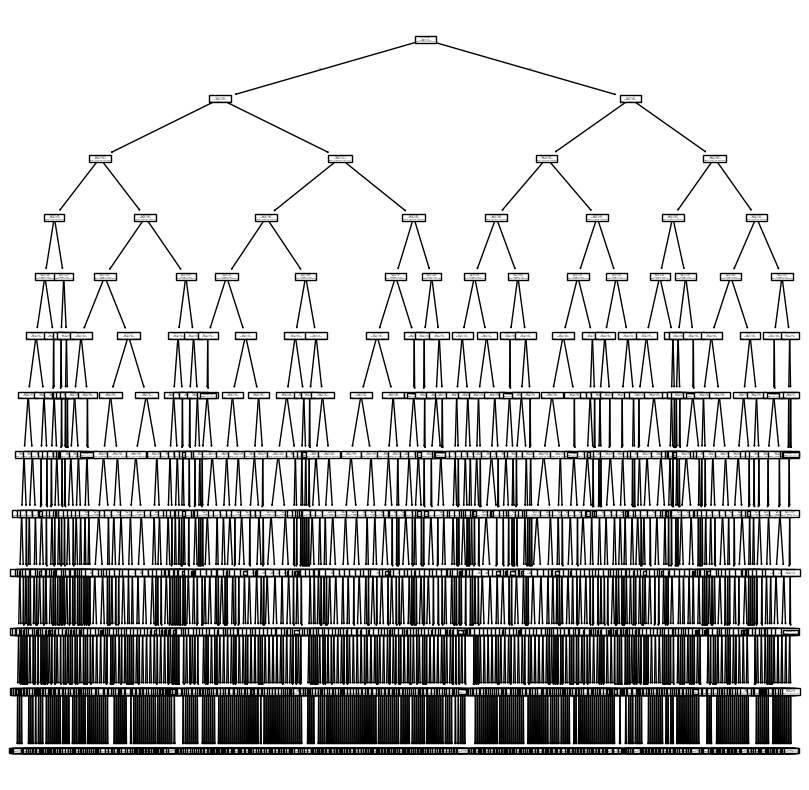

In [262]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_classifer, ax=ax);
plt.savefig('Model_3_Classifier.png')

# Evaluating the model

In [263]:
from sklearn.metrics import confusion_matrix


y_pred = tree_classifer.predict(X_test_transformed)

cfmat = confusion_matrix(y_test,y_pred, labels=tree_classifer.classes_)

In [264]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [265]:
cfmat

array([[8236, 7620],
       [ 684,  844]])

In [269]:

# Inverse transform the target to get original class labels
original_classes = le.inverse_transform([0, 1])


print("Class 0 represents:", original_classes[0])
print("Class 1 represents:", original_classes[1])


Class 0 represents: Otherwise
Class 1 represents: within30


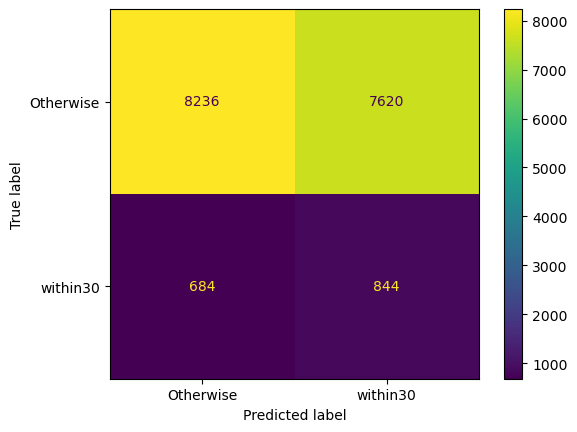

In [270]:

ConfusionMatrixDisplay.from_estimator(tree_classifer, X_test_transformed, y_test, display_labels=original_classes);

In [272]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.850926314573665
Recall: 0.5223193741371376
F1 Score: 0.6212487005685754


In [273]:

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.52      0.66     15856
           1       0.10      0.55      0.17      1528

    accuracy                           0.52     17384
   macro avg       0.51      0.54      0.42     17384
weighted avg       0.85      0.52      0.62     17384



The model is not doing well at predicting the minority class. 

## Hyperparameter Tuning

We will try adjusting the max depth and the class weight to see if it improves the model's performance.

In [274]:
#Initialize the decision tree
tree_classifer = DecisionTreeClassifier(criterion='gini',splitter ='best',random_state=1000, max_depth = 10, class_weight= {0:0.1, 1:0.9} )

#fit it to the training data
tree_classifer.fit(X_train_transformed,y_train)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       random_state=1000)

In [275]:
from sklearn.metrics import confusion_matrix


y_pred_2 = tree_classifer.predict(X_test_transformed)

cfmat_2 = confusion_matrix(y_test,y_pred_2, labels=tree_classifer.classes_)

In [277]:
cfmat_2


array([[9164, 6692],
       [ 769,  759]])

In [278]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.52      0.66     15856
           1       0.10      0.55      0.17      1528

    accuracy                           0.52     17384
   macro avg       0.51      0.54      0.42     17384
weighted avg       0.85      0.52      0.62     17384



Barely any change in the model's performance.

## SMOTE Technique

Next we'll try the SMOTE technique to see if it improves the model's performance.

In [279]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1000)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)



In [280]:

tree_classifer.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       random_state=1000)

In [290]:
y_pred_3 = tree_classifer.predict(X_test_transformed)

cfmat_3 = confusion_matrix(y_test,y_pred_3, labels=tree_classifer.classes_)

In [291]:
cfmat_3

print(classification_report(y_test, y_pred_3))


              precision    recall  f1-score   support

           0       0.94      0.14      0.25     15856
           1       0.09      0.91      0.17      1528

    accuracy                           0.21     17384
   macro avg       0.52      0.53      0.21     17384
weighted avg       0.87      0.21      0.24     17384



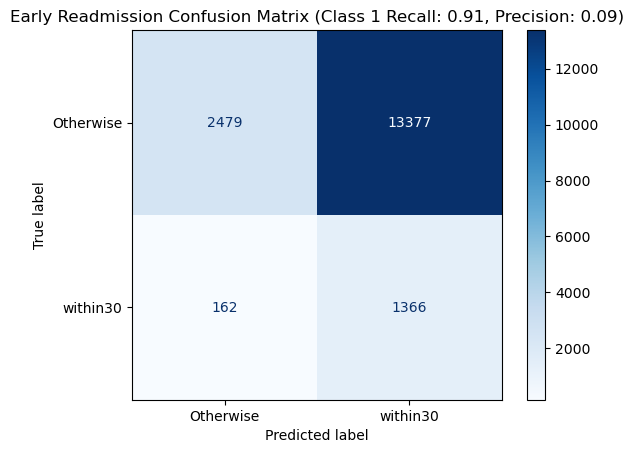

In [300]:
# Display confusion matrix for SMOTE-tuned classifier using ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(tree_classifer, X_test_transformed, y_test, cmap='Blues', display_labels=original_classes)
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_3)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_3)
plt.title(f'Early Readmission Confusion Matrix (Class 1 Recall: {recall:.2f}, Precision: {precision:.2f})')

plt.savefig('Model_3_Confusion_Matrix_SMOTE.png')

SMOTE has dramatically improved the model's ability to predict the minority class. This however came at the cost of low precision. The accuracy is quite low and the model is worse at accurately predicting the majority class.

In [284]:
# Extract values from confusion matrix
tn, fp, fn, tp = cfmat_3.flatten()

# Display the values
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


True Negatives (TN): 9164
False Positives (FP): 6692
False Negatives (FN): 769
True Positives (TP): 759


For our purposes, we care more about recall than precision. The cost of missing a true positive is much higher than the cost of falsely predicting a positive. It also isn't as important for us to predicting a true negative as it is to predicting a true positive. Given true positive represents the patients we positively identify to be readmitted within 30 days, we want to be able to predict as many of those as possible.

We can try to adjust the SMOTE implementation by trying different sampling ratios that are less aggressive.

In [293]:
# Apply a moderate increase in the minority class ratio
smote = SMOTE(sampling_strategy=0.5, random_state=1000)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [294]:
tree_classifer.fit(X_train_resampled, y_train_resampled)


DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       random_state=1000)

In [295]:
cfmat_4= confusion_matrix(y_test,y_pred_3, labels=tree_classifer.classes_)

cfmat_4

array([[ 2274, 13582],
       [  140,  1388]])

In [296]:
y_pred_4 = tree_classifer.predict(X_test_transformed)
print(classification_report(y_test, y_pred_4))


              precision    recall  f1-score   support

           0       0.94      0.16      0.27     15856
           1       0.09      0.89      0.17      1528

    accuracy                           0.22     17384
   macro avg       0.52      0.53      0.22     17384
weighted avg       0.86      0.22      0.26     17384



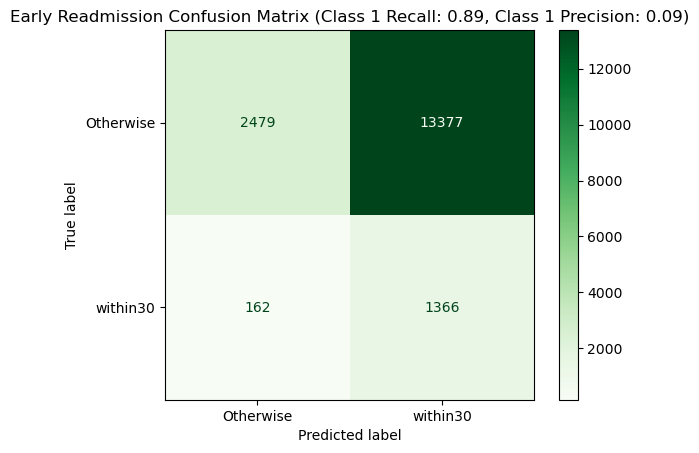

In [298]:
ConfusionMatrixDisplay.from_estimator(tree_classifer, X_test_transformed, y_test, cmap='Greens', display_labels=original_classes)
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_4)
precision = precision_score(y_test, y_pred_4)

plt.title(f'Early Readmission Confusion Matrix (Class 1 Recall: {recall:.2f}, Class 1 Precision: {precision:.2f})')

plt.savefig('Model_3_Confusion_Matrix_SMOTE.png')

Total patients

Findin the optimal threshold to balance precision and recall

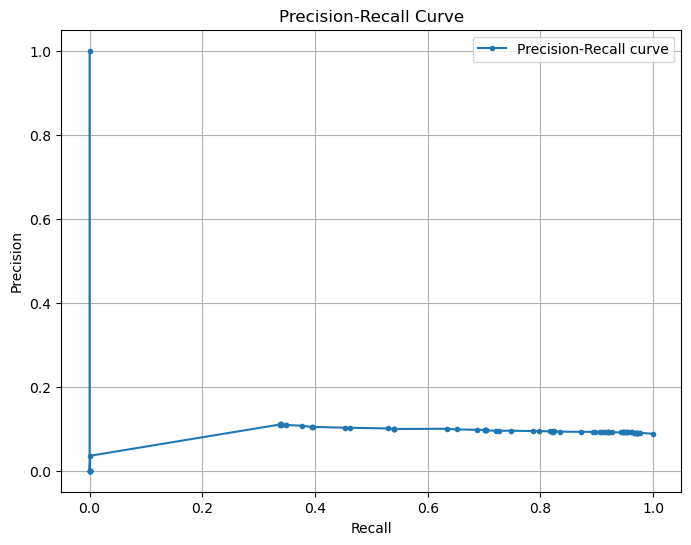

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15856
           1       0.00      0.00      0.00      1528

    accuracy                           0.91     17384
   macro avg       0.46      0.50      0.48     17384
weighted avg       0.83      0.91      0.87     17384



/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_14991/3765011639.py:22: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


In [302]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get probability predictions
y_scores = tree_classifer.predict_proba(X_test_transformed)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Find threshold with best F1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

# Make predictions using the best threshold
y_pred_adjusted = (y_scores >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))

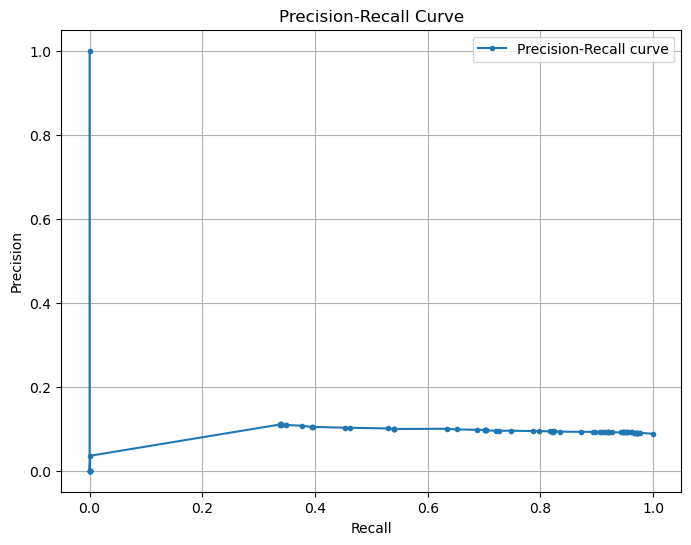

In [304]:
   from sklearn.metrics import precision_recall_curve
   import matplotlib.pyplot as plt

   # Assuming tree_classifier is your fitted model
   y_scores = tree_classifer.predict_proba(X_test_transformed)[:, 1]
   precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

   # Plot the curve
   plt.figure(figsize=(8, 6))
   plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
   plt.xlabel('Recall')
   plt.ylabel('Precision')
   plt.title('Precision-Recall Curve')
   plt.legend()
   plt.grid(True)
   plt.show()

In [305]:
   from collections import Counter
   print(Counter(y_test))

Counter({0: 15856, 1: 1528})


In [307]:
   y_scores = tree_classifer.predict_proba(X_test_transformed)[:, 1]
   print("Unique prediction probabilities:", np.unique(y_scores))
   print("Min probability:", np.min(y_scores))
   print("Max probability:", np.max(y_scores))

Unique prediction probabilities: [0.         0.03813559 0.1        0.10344828 0.10714286 0.125
 0.14937759 0.17307692 0.19014085 0.1942446  0.21028037 0.23376623
 0.24324324 0.27272727 0.28877005 0.3        0.30612245 0.34615385
 0.35294118 0.35526316 0.35744681 0.36206897 0.375      0.39130435
 0.41538462 0.4246824  0.43973941 0.45762712 0.46       0.46153846
 0.46672429 0.47368421 0.50594595 0.51508429 0.5198556  0.52631579
 0.54545455 0.54878049 0.55029586 0.55447268 0.55555556 0.57984265
 0.58587258 0.59302326 0.59564823 0.6        0.6        0.62043796
 0.62068966 0.63829787 0.64178273 0.65336821 0.65967302 0.67176557
 0.69230769 0.71052632 0.72       0.72963927 0.73094133 0.73641851
 0.73847075 0.74585635 0.75       0.76035912 0.76087786 0.76744186
 0.77323944 0.79411765 0.80597015 0.81369863 0.81818182 0.83152174
 0.84040969 0.84210526 0.87096774 0.87096774 0.87096774 0.87804878
 0.9        0.94736842 0.94736842 1.        ]
Min probability: 0.0
Max probability: 1.0


In [308]:
   precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
   print("Precision values:", precision)
   print("Recall values:", recall)

Precision values: [0.08789692 0.09025424 0.09053848 0.09041613 0.09055406 0.09064238
 0.09064757 0.09093704 0.0908979  0.09114567 0.09128192 0.09131306
 0.09126238 0.09126262 0.0913543  0.09117221 0.0912526  0.09123627
 0.09125355 0.09123649 0.09124873 0.09141417 0.0913755  0.09135209
 0.0913996  0.09158416 0.09179188 0.09207144 0.09213052 0.09230769
 0.09230872 0.09253631 0.09265414 0.09251805 0.09316952 0.09343715
 0.09342946 0.09330855 0.09333135 0.09346004 0.09446254 0.09444488
 0.09520634 0.09507495 0.09535748 0.09587454 0.09588309 0.09603713
 0.09695817 0.09698452 0.09717811 0.09736891 0.09829439 0.09992774
 0.0993266  0.09924215 0.09926603 0.09930188 0.10069704 0.10223318
 0.10244264 0.10432833 0.10409822 0.10411622 0.10712293 0.10884215
 0.10944559 0.10975095 0.11002962 0.11012283 0.11016589 0.1099766
 0.11021104 0.03571429 0.         0.         0.         0.
 0.         0.         0.         0.         1.        ]
Recall values: [1.         0.97578534 0.97382199 0.97120419 0.9